<style>
    .latam-title {
            display: inline;
            padding: 20px;
        }
</style>
<div style="text-align: center;">
    <img src="https://download.logo.wine/logo/LATAM_Paraguay/LATAM_Paraguay-Logo.wine.png" alt="LATAM-LOGO" width="200" style="display: inline"/>      
    <h1 style="display: inline;">LATAM Challenge Development</h1>
</div>
<center>
<em>With love by Nicolás Zenteno Guardia</em>
</center>
<center>
<em>August 29th, 2023</em>
</center>
<p><em>Summary:-</em> This work shows the development of the LATAM Challenge sent to the candidates for the "Data Scientist" position. The problem to be solved consists in predicting the probability of delay of the flights that land or take off from the airport of Santiago de Chile
(SCL) using public and real data where each row corresponds to a flight that landed or took off
from SCL during 2017. For this we separe the problem in 5 parts</p>

<ol>
    <li> 
        <a href="#EDA">Exploratory Data Analysis:</a> How is the data distributed? Is there any noteworthy insight to share? What are the  conclusions?
    </li>
    <li> <a href="#DATA_PREP">Data Preparation:</a> Generation of aditional columns, new variables and others.</li>
    <li> <a href="#DELAY_RATE">Pre-Modelling Delay-Rate Understanding:</a> Understanding of the behavior of the delay rate across destination, airline, month of the year, day of the week, season and type of flight.</li>
    <li> <a href="#MODELLING">Modelling:</a> Train different models.</li>
    <li> <a href="#EVALUATION">Evaluation:</a> Evaluate the models.</li>
</ol>



<a id="EDA"><a>
<h1>1. Exploratory Data Analysis</h1>
    <h3>1.1 Import libraries and dataset</h3>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# We get the raw content of the data in this github link.
file_url = "https://raw.githubusercontent.com/nizent/LATAMBestCompany/main/dataset_SCL.csv"

# As the flying numbers, and days, month and years are categorical or discrete numerical variables, we read them as strings not integers and dates as datetime64.
df = pd.read_csv(file_url, dtype={'Vlo-I':'str', 'Vlo-O':'str', 'DIA':'int', 'MES':'int', 'AÑO':'int'}, 
                 parse_dates=['Fecha-I', 'Fecha-O'])

# We assume that 400 and 400.0 are equals 
df["Vlo-I"]=df["Vlo-I"].str.replace('.0','', regex=False)
df["Vlo-O"]=df["Vlo-O"].str.replace('.0','', regex=False)

<h3>1.2 Understand data distribution</h3>

<em>Observations</em> 
<ul>
    <li>We have a total of 68.206 flights. All of them with city origin of Santiago.</li>
    <li>The most common day for flights is Friday, with 15% of flights scheduled in that day.</li>
    <li>The most common month for flights is December, with 9,3% of flights scheduled in that month.</li>
    <li>54% of flights are National and 46% International. </li>
    <li>The most common destination is Buenos Aires, with 9,3% of flights.</li>
    <li>The most common destination code is SCAF (Antofagasta), with 8,5% of flights. <br>
        This could be explained as Buenos Aires has more than one Airport (SAEZ, SABE and SEGU)</li>
    <li>The most common programmed and operating airline is LAN (55,1% and 30,8%).<br> This also means that there are reprogramations of flights with different airlines of the LATAM Group</li>
    <li>There is only one null value, and it is in the operating flight number.</li>
</ul>

In [3]:
description = df.describe(include=['O'])
NaN_count = df.isna().sum()

description.loc['na_count'] = NaN_count
description

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,68206,68206,68206,68206,68205,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206,68206
unique,584,1,64,30,608,1,63,32,31,12,2,7,2,23,1,62
top,174,SCEL,SCFA,LAN,174,SCEL,SCFA,LAN,20,12,2017,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,686,68206,5787,37611,686,68206,5786,20988,2290,6356,68204,10292,36966,40892,68206,6335
na_count,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


<h3>1.2.1 Descriptive analysis by variable</h3>
<br>
As the columns are few, we will analyze each one in detail. The required matplotlib version is at least the 3.4.0 version to use bar_label function.

In [1]:
import matplotlib
print(matplotlib.__version__)

3.5.1


In [69]:
# We define a custom function to plot the categorical column distributions
def valueCountPlot(threshold = 0, column_name = "SIGLADES", figsize = (8,15), color = '#0f91f5', title='Title', ordered=0):
    value_counts_df = df[column_name].value_counts()
    filtered_value_counts = value_counts_df[value_counts_df > threshold]
    number_of_categories = len(filtered_value_counts)
    if ordered:
        filtered_value_counts = filtered_value_counts.sort_index()
        
    if number_of_categories == 1:
        print('There is only one category')
        print(filtered_value_counts)
        return 
    
    figsize = (8, int(number_of_categories/2))
    bars = filtered_value_counts.plot.barh(figsize=figsize, color=color, 
                                                   title=title)
    ax = plt.gca()
    bars.bar_label(bars.containers[0])
    ax.invert_yaxis()
    visible_spines = {'top': 0, 'left': 1, 'bottom': 0, 'right': 0}
    ax_customization = [ax.spines[key].set_visible(value) for key, value in visible_spines.items()]
    plt.show()
    return

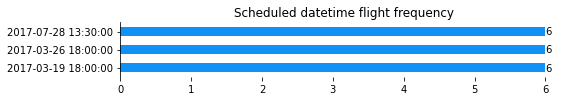

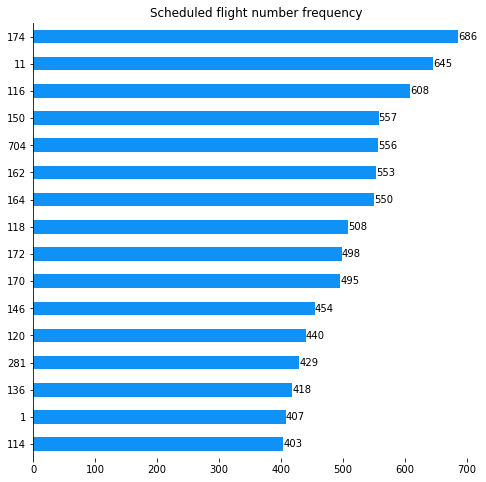

There is only one category
SCEL    68206
Name: Ori-I, dtype: int64


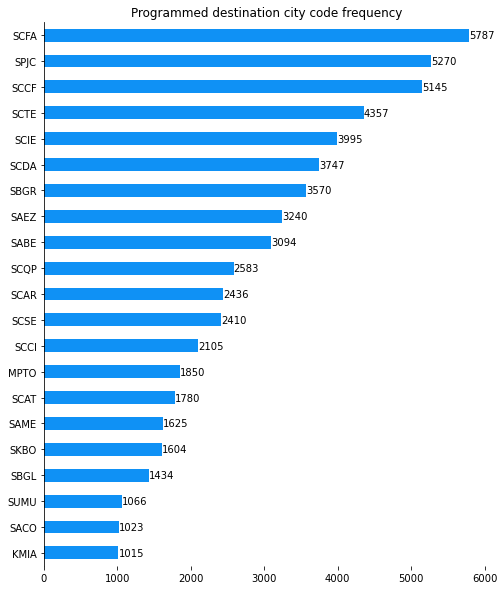

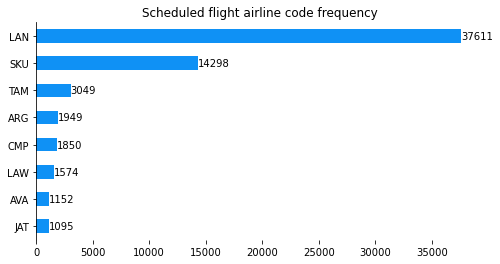

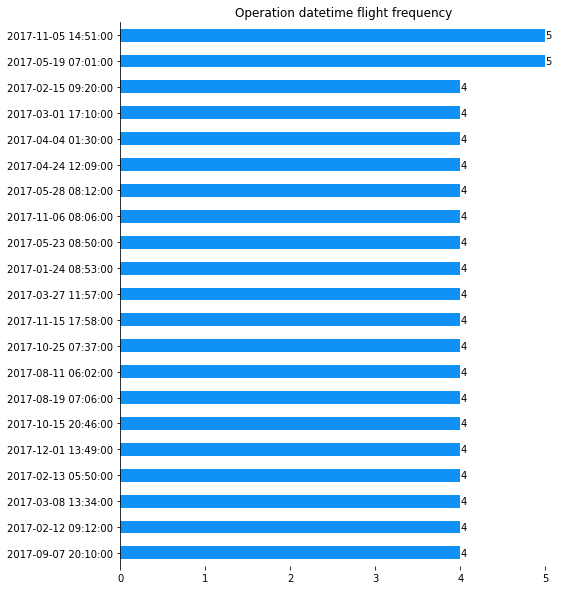

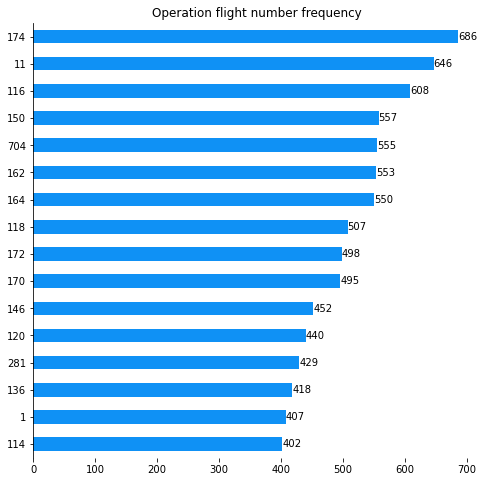

There is only one category
SCEL    68206
Name: Ori-O, dtype: int64


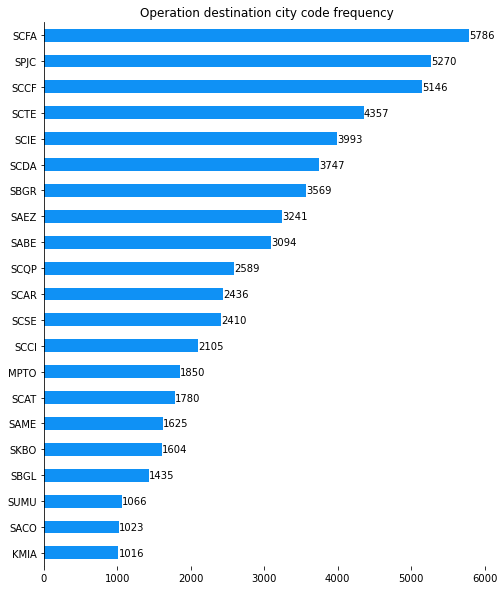

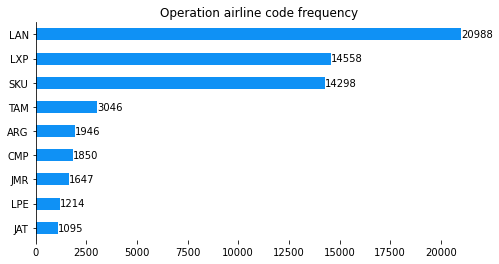

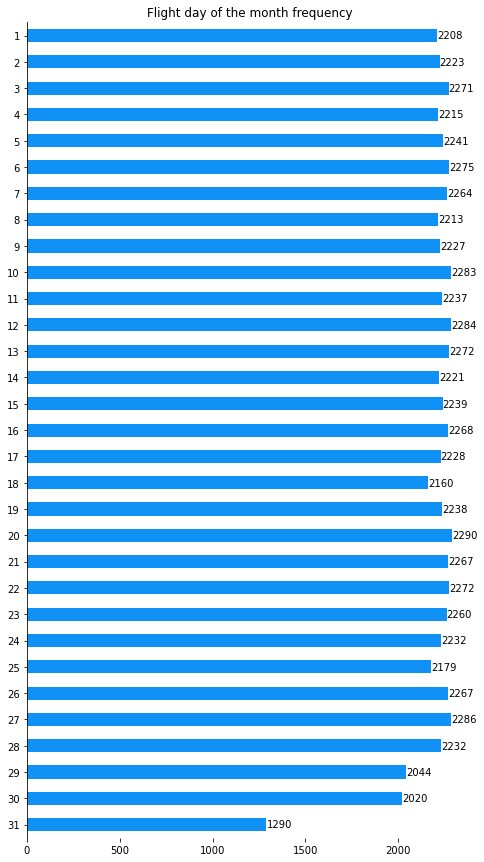

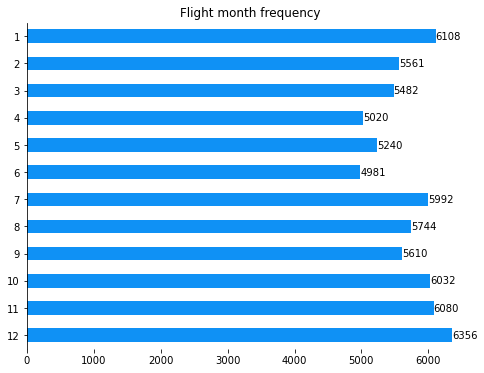

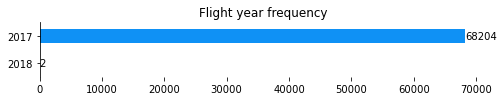

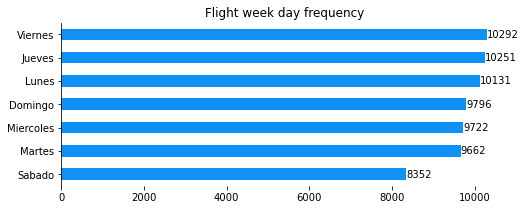

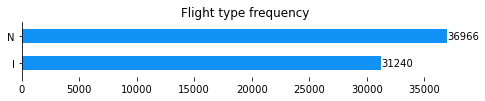

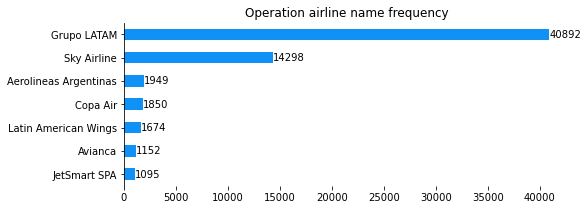

There is only one category
Santiago    68206
Name: SIGLAORI, dtype: int64


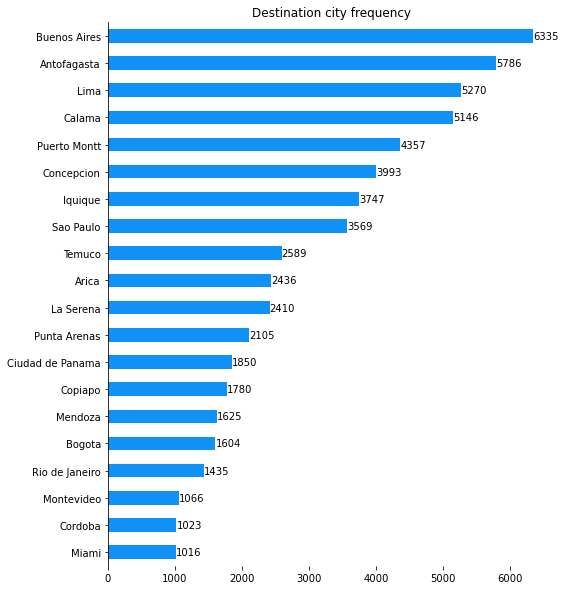

In [75]:
interpretable_column_name = {'Fecha-I': ['Scheduled datetime flight', 0], 'Vlo-I': ['Scheduled flight number', 0], 'Ori-I': ['Programmed origin city code', 0], 'Des-I': ['Programmed destination city code', 0], 'Emp-I': ['Scheduled flight airline code', 0], 'Fecha-O': ['Operation datetime flight', 0], 'Vlo-O': ['Operation flight number', 0], 'Ori-O': ['Operation origin city code', 0], 'Des-O': ['Operation destination city code', 0], 'Emp-O': ['Operation airline code', 0], 'DIA': ['Flight day of the month', 1], 'MES': ['Flight month', 1], 'AÑO': ['Flight year', 0], 'DIANOM': ['Flight week day', 0], 'TIPOVUELO': ['Flight type', 0], 'OPERA': ['Operation airline name', 0], 'SIGLAORI': ['City of origin', 0], 'SIGLADES': ['Destination city', 0]}
thresholds={'Fecha-I': 5, 'Vlo-I': 400, 'Ori-I': 1000, 'Des-I': 1000, 'Emp-I': 1000, 'Fecha-O': 3, 'Vlo-O': 400, 'Ori-O': 1000, 'Des-O': 1000, 'Emp-O': 1000, 'DIA': 0, 'MES': 0, 'AÑO': 0, 'DIANOM': 1000, 'TIPOVUELO': 1000, 'OPERA': 1000, 'SIGLAORI': 1000, 'SIGLADES': 1000}
comments={'Fecha-I': 'The maximum flights in a date and time is 6 flights.', 
          'Vlo-I': 'Most repeated flight numbers are #174, #11, #116', 'Ori-I': '', 
          'Des-I': 'SCFA, SPJC, SCCF are the most frequent scheduled destinations.', 
          'Emp-I': 'Most scheduled airlines are LAN and SKU.', 
          'Fecha-O': 'There are flights at the the same operation date times.', 
          'Vlo-O': 'The most frequent operation flight numbers are the same as the scheduled.', 'Ori-O': '',
          'Des-O': 'The same as scheduled.', 
          'Emp-O': 'The most frequent operation airlines are LAN, LXP and SKU.', 
          'DIA': 'The least frequent day of the month is 31, this could be explained as not all months have a 31 day. The majority of days have similar frequency.',
          'MES': 'The months with more frequency are January, December, November, October and July. All of them months where holidays are frequent or it is summer (except by July).', 
          'AÑO': 'There are two flights at 2018.', 
          'DIANOM': 'The days where are more flights are in Friday, Thursday and Monday. This could be due to take more advantage of the weekend, in the case of Friday and Thursday.', 
          'TIPOVUELO': 'There are more national flights.', 
          'OPERA': 'The operating airlines are in majority LATAM and SKY',
          'SIGLAORI': '', 'SIGLADES': 'Most frequent destinations are Buenos Aires, Antofagasta, Lima and Calama. As Chile is a Mining country, the mines are in the north, that could explain Antofagasta and Calama.'}
for column_name, params in interpretable_column_name.items():
    title, ordered = params[0], params[1] 
    display(HTML(f'<h3>{title}</h3>'))
    valueCountPlot(column_name = column_name, title=f'{title} frequency', threshold=thresholds[column_name], ordered=ordered)
    display(HTML(f'<p>{comments[column_name]}</p>'))

<h3>Q1: How is the data distributed? Is there any noteworthy insight to share? What are the  conclusions?</h3>
We can summarize the analysis in these points.
<ol>
    <li><b>DAY, MONTH and YEAR (numeric)</b>
        <p>The months with most frequency are January and December. That could be explained as these months are high season months which is preferred by Chileans to travel as they commonly take vacations in this season as the children don't go to school during that. The month with less flights is June, this month is at low season and could be explained with that. Another month that highlights is July, when scholars have winter holidays and it is frequent for travels with the family.</p><p>Also, the fact that in summer or high season the weather is better for flights, there is more probability of operational success in the flights. Otherwise, in winter in months as June, there are climatic conditions that can affect the operations of the airline.</p><p>The days of the months have an homogeneous distribution, except by the day 31 which only 7 months have it.</p><p>It is not recommendable to use the year as variable in thec model as it only have 2 values and mostly 2017, that would only inrease complexity, this applies for all columns that have only one value.</p><p></p>
    </li> 
    <li>
        <b>Categorical values</b>
        <p>The most frequent destinations are Buenos Aires, Antofagasta, Lima and Calama, representing 33% of flights. This could be explained as:</p><p>1. Chilean industry: Mining, Fishery, Cellulose among others industries that have their operations along Chile. Specially the mining sector where the operations are at different parts of the nort of Chile as Calama and Antofagasta (Antofagasta Minerals, Codelco, BHP, Anglo American) where their workers have to travel each week.</p>
        <p>2. Geographical proximity, culture and commerce: As Argentina, Perú are near to Chile and its native language is Spanish, it is a common destination for travelers, also, the proximity offers more affordable destinations for the people. In addition, these countries have a strong market relationship with Chile.</p>
        <p>The dataset is congruent with the fact that LATAM is the greatest airline in Latin America and is extended abroad Chile, offering a lot of options to travel along the country, with SKY, the second largest one in the country represents 80,9% of the flights.</p><p></p>
        <p><em>Technical observations:</em> Vlo-{I,O} have a lot of values as they are identifiers, it has no sense to put it in a model. And Ori-{I,O}, SIGLAORI have unique value, so adding those to a model would be useless.</p>
    </li>
</ol>

<a id="DATA_PREP"></a>
<h1>2. Data Preparation</h1>
<p>In this section of the work we will add some features to the dataset to understand in a better way the behavior of delay rates. For this we need to create new columns</p>
<ul>
    <li><u>high_season :</u> 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.</li>
    <li><u>min_diff :</u> difference in minutes between Date-O and Date-I .</li>
    <li><u>delay_15 :</u> 1 if min_diff > 15, 0 if not.</li>
    <li><u>period_day :</u> morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I .</li> 
</ul>

<h3>2.1 Creation of columns </h3>
We proceed to create the columns.

In [32]:
# As all the scheduled dates are for 2017, we can do this, if there would be more years we would use another way
high_season_bins = [df['Fecha-I'].min()]+[pd.to_datetime(f'2017-{date}') for date in ['03-03', '07-15', '07-31', '09-11', '09-30', '12-15']]+[pd.to_datetime('2018-01-01')]
high_season_labels = [1,0,1,0,1,0,1]
df['high_season'] = pd.cut(df['Fecha-I'], bins=high_season_bins, labels=high_season_labels, ordered=False, include_lowest=True)

# We get the difference in minutes
df['min_diff'] = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60

# We classify the delay with a 15 minutes breakpoint
df['delay_15'] = (df['min_diff'] > 15).astype(int)

# We classify the hour of the day
period_day_bins = [0, 5, 12, 19, 24]
period_day_labels = ['night', 'morning', 'afternoon', 'night']
df['period_day'] = pd.cut(df['Fecha-I'].dt.hour, bins=period_day_bins, labels=period_day_labels, ordered=False, include_lowest=True)

<h3>2.2 Creation of dataset </h3>
We export them to a CSV file named synthetic_features.csv

In [34]:
df[['high_season', 'min_diff', 'delay_15', 'period_day']].to_csv('synthetic_features.csv')